# Description
数据集500_Person_Gender_Height_Weight.csv中包含了500份数据，数据的构成如下所示：


|  | Gender | Height | Weight
|:---:|:---:|:---:|:---:|
| Sample1 | Male | 174 | 96 |
| Sample2 | Female | 185 | 110 |

其中第一列表示性别，第二列表示身高，第三列表示体重，试用贝叶斯分类器构建分类器，根据身高和体重区分样本的性别。

## Requirements
1. 构造贝叶斯分类器
2. 可视化贝叶斯分类器决策面
3. 预测身高为180体重为120的样本的性别
4. 完成实验报告

# Solution
## Pre-processing data

In [552]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv('traindata.csv', sep=',').dropna() # drop nan rows

male = df_train.loc[df_train['gender']=='Male'].iloc[:,1:3].to_numpy() # male matrix
female = df_train.loc[df_train['gender']=='Female'].iloc[:,1:3].to_numpy() # female matrix

n_male = len(male) # number of male saples
n_female = len(female) # number of female saples

## Visualizing Data

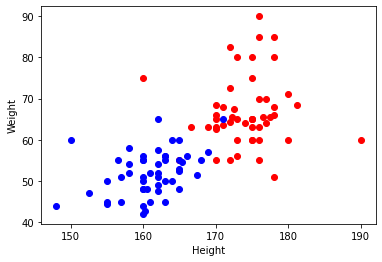

In [553]:
plt.xlabel('Height')
plt.ylabel('Weight')
plt.scatter(x=male[:,0],y=male[:,1], c={'red':'male'})
plt.scatter(x=female[:,0],y=female[:,1],  c={'blue':'Female'})

## Calculating mean and covariance

In [554]:
def calc_param(feature):
  height_mean = feature[:,0].mean()
  weight_mean = feature[:,1].mean()
  cov = np.cov(feature.T)
  return height_mean, weight_mean, cov

In [555]:
male_height_mean, male_weight_mean, cov_male = calc_param(male)
female_height_mean, female_weight_mean, cov_female = calc_param(female)
mean_male = np.array([male_height_mean, male_weight_mean]).reshape(-1,1)
mean_female = np.array([female_height_mean, female_weight_mean]).reshape(-1,1)

prior_male = len(male)/(len(male) + len(female))
prior_female = 1 - prior_male

## Predict

In [556]:
def multivar_guassian(x, mean, cov):
  return np.exp(-0.5 * (np.dot(np.dot((x - mean).T,np.linalg.inv(cov)), x - mean))) / ((2 * np.pi) * np.sqrt(np.linalg.det(cov)))

def pred(x, sex):
  if sex.lower() == 'male':
    return multivar_guassian(x,mean_male, cov_male) * prior_male / (multivar_guassian(x, mean_male, cov_male) * prior_male + multivar_guassian(x, mean_female, cov_female) * prior_female)
  elif sex.lower() == 'female':
    return multivar_guassian(x,mean_female, cov_female) * prior_female / (multivar_guassian(x, mean_male, cov_male) * prior_male + multivar_guassian(x, mean_female, cov_female) * prior_female)

## Visualizing decision boundary

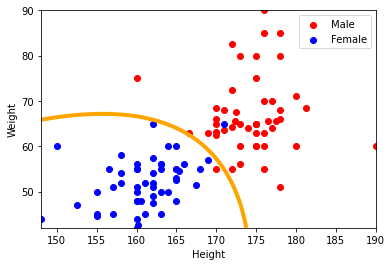

In [557]:
def plot_data(prediction, male, female):
  sample_height = np.linspace(np.min(female[:,0]),np.max(male[:,0]),50)
  sample_weight = np.linspace(np.min(female[:,1]),np.max(male[:,1]),50)

  sample_pred = np.zeros((50, 50))

  for i in range(50):
    for j in range(50):
      x = np.array([sample_height[i],sample_weight[j]]).reshape(-1,1)
      sample_pred[i,j] = prediction(x)

  # 把预测值为0的线画出来作为边界
  plt.contour(sample_height, sample_weight, sample_pred, 0, colors = 'orange', linewidths=4) 
  plt.xlabel('Height')
  plt.ylabel('Weight')
  plt.scatter(x=male[:,0], y=male[:,1], c={'red':'Male'})
  plt.scatter(x=female[:,0], y=female[:,1], c={'blue':'Female'})
  plt.legend(['Male', 'Female'])

plot_data(lambda x : pred(x, 'male') - pred(x, 'female'), male, female) # 若男的概率>女则为男

## ROC

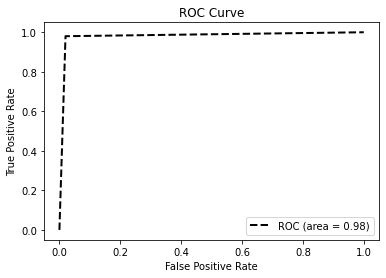

In [558]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def roc(predict, xs, ys):
    # predict given samples
    result = [0 if (predict(x.reshape([-1,1]), 'male') - pred(x.reshape([-1,1]), 'female')) > 0 else 1 for x in xs ]

    # calc fpr and tpr
    fpr, tpr, thersholds = roc_curve(ys, result)

    # clac auc
    roc_auc = auc(fpr, tpr)

    # plot ROC cureve
    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

ys = df_train['gender'].map({label:idx for idx,label in enumerate(set(df_train['gender']))}).to_numpy()
xs = df_train.iloc[:,1:3].to_numpy()
roc(pred, xs, ys)

# Testing

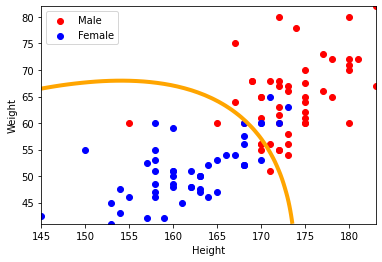

In [559]:
# read testing set
df_test = pd.read_csv('testdata.csv', sep=',').dropna()
male = df_test.loc[df_train['gender']=='Male'].iloc[:,1:3].to_numpy() # male matrix
female = df_test.loc[df_train['gender']=='Female'].iloc[:,1:3].to_numpy() # female matrix

# plot
plot_data(lambda x : pred(x,'male') - pred(x,'female'), male, female)

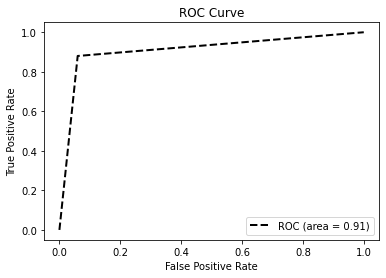

In [560]:
ys = df_test['gender'].map({label:idx for idx,label in enumerate(set(df_train['gender']))}).to_numpy()
xs = df_test.iloc[:,1:3].to_numpy()
roc(pred, xs, ys)

In [562]:
ret = pred(np.array([[180],[120]]),'male') - pred(np.array([[180],[120]]),'female')
print(ret.flatten())

[1.]
